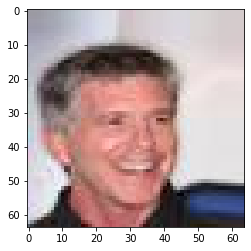

In [3]:
#Create a folder called celeba in home dir where reconstructed images will be stored
#Considered only 100000 images for training

import os
import torch
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch.utils.data as utils
import gc
import pywt
import IPython
import random
from random import sample
with __import__('importnb').Notebook():
        from wtvae_wt64 import CelebaDataset, VAE, Flatten

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
# os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
CUDA = True
BATCH_SIZE = 32
LOG_INTERVAL = 5
h_img = 64
w_img = 64
flat = h_img*w_img*3
train_losses = []

In [4]:
w=pywt.Wavelet('bior2.2')


dec_hi = torch.Tensor(w.dec_hi[::-1]).cuda() 
dec_lo = torch.Tensor(w.dec_lo[::-1]).cuda()
rec_hi = torch.Tensor(w.rec_hi).cuda()
rec_lo = torch.Tensor(w.rec_lo).cuda()

inv_filters = torch.stack([rec_lo.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_lo.unsqueeze(0)*rec_hi.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_lo.unsqueeze(1),
                           rec_hi.unsqueeze(0)*rec_hi.unsqueeze(1)], dim=0)

def iwt(vres, levels=1):
    h = vres.size(2)
    w = vres.size(3)
    res = vres.contiguous().view(-1,h//2,2,w//2).transpose(1,2).contiguous().view(-1,4,h//2,w//2).clone()
    print(res.shape)
    if levels>1:
        res[:,:1] = iwt(res[:,:1], levels=levels-1)
    res = torch.nn.functional.conv_transpose2d(res, Variable(inv_filters[:,None]),stride=2)
    res = res[:,:,2:-2,2:-2] #removing padding
#     print(res.shape)
    return res

def truncated_normal_(tensor, mean=0, std=0.02):
    size = tensor.shape
    tmp = tensor.new_empty(size + (4,)).normal_()
    valid = (tmp < 2) & (tmp > -2)
    ind = valid.max(-1, keepdim=True)[1]
    tensor.data.copy_(tmp.gather(-1, ind).squeeze(-1))
    tensor.data.mul_(std).add_(mean)
    
def weights_init(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        with torch.no_grad():
            truncated_normal_(m.weight.data, mean=0, std=0.02)
        nn.init.constant_(m.bias.data, 0.0)
    elif isinstance(m, nn.Linear):
        nn.init.normal_(m.weight.data, mean=0, std=0.02)
        nn.init.constant_(m.bias.data, 0.0)

In [27]:
class LearnIWT(nn.Module):
    def __init__(self, image_channels=3, z_dim=100, device=None):
        super(LearnIWT, self).__init__()
        
        if device is None:
            self.cuda = False
            self.device = None
        else:
            self.device = device
            self.cuda = True
        
        self.z_dim = z_dim
        self.leakyrelu = nn.LeakyReLU(0.2)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

        # X - Y Residual Encoder
        self.e1 = nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 64, 32, 32]
        weights_init(self.e1)
        self.instance_norm_e1 = nn.InstanceNorm2d(num_features=64, affine=False)

        self.e2 = nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 128, 16, 16]
        weights_init(self.e2)
        self.instance_norm_e2 = nn.InstanceNorm2d(num_features=128, affine=False)

        self.e3 = nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 256, 8, 8]
        weights_init(self.e3)
        self.instance_norm_e3 = nn.InstanceNorm2d(num_features=256, affine=False)

        self.e4 = nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=True, padding_mode='zeros') #[b, 512, 4, 4]
        weights_init(self.e4)
        self.instance_norm_e4 = nn.InstanceNorm2d(num_features=512, affine=False)
        
        self.fc_enc = nn.Linear(512 * 4 * 4, 256)
        weights_init(self.fc_enc)
        
        self.fc_mean = nn.Linear(256, z_dim)
        weights_init(self.fc_mean)
        
        self.fc_var = nn.Linear(256, z_dim)
        weights_init(self.fc_var)
        
        # IWT Decoder        
        self.d1 = nn.Linear(3 * 64 * 64, 3 * 64 * 64)
        weights_init(self.d1)
        self.mu1 = nn.Linear(z_dim, 3 * 64 * 64)
        self.var1 = nn.Linear(z_dim, 3 * 64 * 64)
        self.instance_norm_d1 = nn.InstanceNorm2d(num_features=3, affine=False)
        self.iwt1 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2)
        
        self.d2 = nn.Linear(3 * 64 * 64, 3 * 64 * 64)
        weights_init(self.d2)
        self.mu2 = nn.Linear(z_dim, 3 * 64 * 64)
        self.var2 = nn.Linear(z_dim, 3 * 64 * 64)
        self.instance_norm_d2 = nn.InstanceNorm2d(num_features=3, affine=False)
        self.iwt2 = nn.ConvTranspose2d(image_channels, image_channels, kernel_size=5, stride=1, padding=2)
        
    
    def encode(self, x, y):
        h = self.leakyrelu(self.instance_norm_e1(self.e1(x-y)))   #[b, 64, 32, 32]
        h = self.leakyrelu(self.instance_norm_e2(self.e2(h)))     #[b, 128, 16, 16]
        h = self.leakyrelu(self.instance_norm_e3(self.e3(h)))     #[b, 256, 8, 8]
        h = self.leakyrelu(self.instance_norm_e4(self.e4(h)))     #[b, 512, 4, 4]
        h = self.leakyrelu(self.fc_enc(h.view(-1,512*4*4)))       #[b, 512 * 4 * 4]
        
        return self.fc_mean(h), F.softplus(self.fc_var(h))        #[b, z_dim]

    def reparameterize(self, mu, var):
        std = torch.sqrt(var)
        if self.cuda:
            eps = torch.FloatTensor(std.size()).normal_().to(self.device)
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu) 
    
    def decode(self, y, z):
        mu = self.mu1(z).reshape(-1, 3, 64, 64)
        var = self.var1(z).reshape(-1, 3, 64, 64)
        h = self.leakyrelu(var*self.instance_norm_d1(self.d1(y.view(y.shape[0], -1)).reshape(-1, 3, 64, 64)) + mu) #[b, 3, 64, 64]
        h = self.leakyrelu(self.iwt1(h))                               #[b, 3, 64, 64]
        
#         mu = self.mu2(z).reshape(-1, 3, 64, 64)
#         var = self.var2(z).reshape(-1, 3, 64, 64)
#         h = self.leakyrelu(var*self.instance_norm_d2(self.d1(h.view(h.shape[0], -1)).reshape(-1, 3, 64, 64)) + mu) #[b, 3, 64, 64]
        h = self.leakyrelu(self.iwt2(h))                               #[b, 3, 64, 64]
        
        return self.sigmoid(h)
        
        
    def forward(self, x, y):
        mu, var = self.encode(x, y)
        if self.training:
            z = self.reparameterize(mu, var)
        else:
            z = mu
        x_hat = self.decode(y, z)
        
        return x_hat, mu, var
        
        
    def loss_function(self, x, x_hat, mu, var) -> Variable:
        
        # Loss btw reconstructed img and original img
        BCE = F.mse_loss(x_hat.view(-1), x.view(-1))
        
        logvar = torch.log(var)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) * 0.01
#         KLD /= x.shape[0] * 3 * 64 * 64

        return BCE + KLD
        
        
        

In [ ]:
# test = torch.zeros((32,3,32,32))
# test1 = test.contiguous().view(-1,32//2,2,32//2).transpose(1,2).contiguous().view(-1,4,32//2,32//2).clone()
# print(test1.shape)
# #torch.nn.functional.conv_transpose2d(test1.cuda(), Variable(inv_filters[:,None]),stride=2)
# t = nn.ConvTranspose2d(3, 3, kernel_size=6, stride=2)
# t1 = Variable(inv_filters[:,None])
# print(t1.shape)
# print(t.weight.shape)

# with torch.no_grad():
#     t.weight = torch.nn.Parameter(t1)

In [9]:
# Create celeba dataset
root_dir = '/disk_c/han/'
img_dir = os.path.join(root_dir, 'celeba64/')
image_files = os.listdir(img_dir)
train_dataset = CelebaDataset(img_dir, image_files, WT=False)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=10, shuffle=True)
sample_dataset = Subset(train_dataset, sample(range(len(train_dataset)), 8))
sample_loader = DataLoader(sample_dataset, batch_size=8, shuffle=False)

In [7]:
# Zeroing out all other patches than the first for WT image: 4D: B * C * H * W
def zero_patches(img):
    zeros = torch.zeros((img.shape[0], img.shape[1], img.shape[2], img.shape[3]))
    zeros[:,:,:16,:16] = img[:,:,:16,:16]
    
    return zeros

In [8]:
def train(epoch, model, optimizer, train_loader):
    # toggle model to train mode
    model.train()
    train_loss = 0
    
    for batch_idx, data in enumerate(train_loader):
        
        if CUDA:
            data0 = data.to('cuda:0')
            data1 = data.clone().to('cuda:1')

        optimizer.zero_grad()
        
        # Get Y
        Y = wt_model(data1)[0]
        # Zeroing out all other patches
        Y = zero_patches(Y)
        x_hat, mu, var = iwt_model(data0, Y.to('cuda:0'))
        # Fix loss function
        loss = iwt_model.loss_function(x_hat, data0, mu, var)
        loss.backward()
        
        train_losses.append(loss.item())
        train_loss += loss
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data),
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss / len(data)))
            
            n = min(data.size(0), 8)  

    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

In [28]:
# Loading WT model and setting to eval for inference
wt_model = VAE()
wt_model.load_state_dict(torch.load(os.path.join(root_dir, 'wtvae_models_2wt/wtvae_epoch88.pth')))
wt_model.to('cuda:1')
wt_model.eval()
iwt_model = LearnIWT(device='cuda:0').to('cuda:0')

postfix = 'rest0_1unsample'
sample_dir = os.path.join(root_dir, 'image_samples/')
model_dir = os.path.join(root_dir, 'models/')
if os.path.isdir('/disk_c/han/image_samples/celeba_iwtvae_{}'.format(postfix)) or os.path.isdir('/disk_c/han/models/iwtvae64_models_{}'.format(postfix)):
    raise Exception('Image sample / model directory exists!')
else:
    os.mkdir('/disk_c/han/image_samples/celeba_iwtvae_{}'.format(postfix))
    os.mkdir('/disk_c/han/models/iwtvae64_models_{}'.format(postfix))
             
train_losses = []
gc.collect()
EPOCHS = 100

optimizer = optim.Adam(iwt_model.parameters(), lr=1e-3)

for epoch in range(1, EPOCHS + 1):
    train(epoch, iwt_model, optimizer, train_loader)

    with torch.no_grad():
        iwt_model.eval()

        for data in sample_loader:
            if CUDA:
                data0 = data.to('cuda:0')
                data1 = data.to('cuda:1')
            
            z_sample = torch.randn(data.shape[0],100).to('cuda:0')
            
            Y = wt_model(data1)[0].to('cuda:0')
            mu, var = iwt_model.encode(data0, Y)
            x_hat = iwt_model.decode(Y, mu)
            x_sample = iwt_model.decode(Y, z_sample)
            
            save_image(x_hat.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_recon'.format(postfix) + str(epoch) + '.png') 
            save_image(x_sample.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_z'.format(postfix) + str(epoch) + '.png')
            save_image(Y.cpu(), sample_dir + '/celeba_iwtvae_{}/sample_y'.format(postfix) + str(epoch) + '.png') 
            save_image(data.cpu(), sample_dir + '/celeba_iwtvae_{}/sample'.format(postfix) + str(epoch) + '.png')  
    
    torch.save(iwt_model.state_dict(), model_dir + '/iwtvae64_models_{}/iwtvae_epoch{}.pth'.format(postfix, epoch))

Train Epoch: 1 [0/10000 (0%)]	Loss: 0.078086
Train Epoch: 1 [160/10000 (2%)]	Loss: 0.032207
Train Epoch: 1 [320/10000 (3%)]	Loss: 0.010548
Train Epoch: 1 [480/10000 (5%)]	Loss: 0.006377
Train Epoch: 1 [640/10000 (6%)]	Loss: 0.004889
Train Epoch: 1 [800/10000 (8%)]	Loss: 0.003880
Train Epoch: 1 [960/10000 (10%)]	Loss: 0.003356
Train Epoch: 1 [1120/10000 (11%)]	Loss: 0.003261
Train Epoch: 1 [1280/10000 (13%)]	Loss: 0.003016
Train Epoch: 1 [1440/10000 (14%)]	Loss: 0.002641
Train Epoch: 1 [1600/10000 (16%)]	Loss: 0.002690
Train Epoch: 1 [1760/10000 (18%)]	Loss: 0.002727
Train Epoch: 1 [1920/10000 (19%)]	Loss: 0.002380
Train Epoch: 1 [2080/10000 (21%)]	Loss: 0.002641
Train Epoch: 1 [2240/10000 (22%)]	Loss: 0.002636
Train Epoch: 1 [2400/10000 (24%)]	Loss: 0.002474
Train Epoch: 1 [2560/10000 (26%)]	Loss: 0.002685
Train Epoch: 1 [2720/10000 (27%)]	Loss: 0.002370
Train Epoch: 1 [2880/10000 (29%)]	Loss: 0.002532
Train Epoch: 1 [3040/10000 (30%)]	Loss: 0.002310
Train Epoch: 1 [3200/10000 (32%)]	L

Train Epoch: 3 [6560/10000 (65%)]	Loss: 0.000600
Train Epoch: 3 [6720/10000 (67%)]	Loss: 0.000661
Train Epoch: 3 [6880/10000 (69%)]	Loss: 0.000734
Train Epoch: 3 [7040/10000 (70%)]	Loss: 0.000614
Train Epoch: 3 [7200/10000 (72%)]	Loss: 0.000676
Train Epoch: 3 [7360/10000 (73%)]	Loss: 0.000744
Train Epoch: 3 [7520/10000 (75%)]	Loss: 0.000653
Train Epoch: 3 [7680/10000 (77%)]	Loss: 0.000693
Train Epoch: 3 [7840/10000 (78%)]	Loss: 0.000696
Train Epoch: 3 [8000/10000 (80%)]	Loss: 0.000638
Train Epoch: 3 [8160/10000 (81%)]	Loss: 0.000607
Train Epoch: 3 [8320/10000 (83%)]	Loss: 0.000651
Train Epoch: 3 [8480/10000 (85%)]	Loss: 0.000720
Train Epoch: 3 [8640/10000 (86%)]	Loss: 0.000599
Train Epoch: 3 [8800/10000 (88%)]	Loss: 0.000643
Train Epoch: 3 [8960/10000 (89%)]	Loss: 0.000691
Train Epoch: 3 [9120/10000 (91%)]	Loss: 0.000647
Train Epoch: 3 [9280/10000 (93%)]	Loss: 0.000733
Train Epoch: 3 [9440/10000 (94%)]	Loss: 0.000622
Train Epoch: 3 [9600/10000 (96%)]	Loss: 0.000641
Train Epoch: 3 [9760

Train Epoch: 6 [2880/10000 (29%)]	Loss: 0.000586
Train Epoch: 6 [3040/10000 (30%)]	Loss: 0.000624
Train Epoch: 6 [3200/10000 (32%)]	Loss: 0.000599
Train Epoch: 6 [3360/10000 (34%)]	Loss: 0.000580
Train Epoch: 6 [3520/10000 (35%)]	Loss: 0.000477
Train Epoch: 6 [3680/10000 (37%)]	Loss: 0.000647
Train Epoch: 6 [3840/10000 (38%)]	Loss: 0.000517
Train Epoch: 6 [4000/10000 (40%)]	Loss: 0.000637
Train Epoch: 6 [4160/10000 (42%)]	Loss: 0.000575
Train Epoch: 6 [4320/10000 (43%)]	Loss: 0.000545
Train Epoch: 6 [4480/10000 (45%)]	Loss: 0.000574
Train Epoch: 6 [4640/10000 (46%)]	Loss: 0.000523
Train Epoch: 6 [4800/10000 (48%)]	Loss: 0.000562
Train Epoch: 6 [4960/10000 (50%)]	Loss: 0.000562
Train Epoch: 6 [5120/10000 (51%)]	Loss: 0.000590
Train Epoch: 6 [5280/10000 (53%)]	Loss: 0.000501
Train Epoch: 6 [5440/10000 (54%)]	Loss: 0.000604
Train Epoch: 6 [5600/10000 (56%)]	Loss: 0.000546
Train Epoch: 6 [5760/10000 (58%)]	Loss: 0.000543
Train Epoch: 6 [5920/10000 (59%)]	Loss: 0.000546
Train Epoch: 6 [6080

Train Epoch: 8 [9440/10000 (94%)]	Loss: 0.000521
Train Epoch: 8 [9600/10000 (96%)]	Loss: 0.000576
Train Epoch: 8 [9760/10000 (97%)]	Loss: 0.000578
Train Epoch: 8 [9920/10000 (99%)]	Loss: 0.000546
====> Epoch: 8 Average loss: 0.0005
Train Epoch: 9 [0/10000 (0%)]	Loss: 0.000541
Train Epoch: 9 [160/10000 (2%)]	Loss: 0.000585
Train Epoch: 9 [320/10000 (3%)]	Loss: 0.000558
Train Epoch: 9 [480/10000 (5%)]	Loss: 0.000494
Train Epoch: 9 [640/10000 (6%)]	Loss: 0.000527
Train Epoch: 9 [800/10000 (8%)]	Loss: 0.000575
Train Epoch: 9 [960/10000 (10%)]	Loss: 0.000574
Train Epoch: 9 [1120/10000 (11%)]	Loss: 0.000562
Train Epoch: 9 [1280/10000 (13%)]	Loss: 0.000459
Train Epoch: 9 [1440/10000 (14%)]	Loss: 0.000565
Train Epoch: 9 [1600/10000 (16%)]	Loss: 0.000543
Train Epoch: 9 [1760/10000 (18%)]	Loss: 0.000509
Train Epoch: 9 [1920/10000 (19%)]	Loss: 0.000524
Train Epoch: 9 [2080/10000 (21%)]	Loss: 0.000561
Train Epoch: 9 [2240/10000 (22%)]	Loss: 0.000612
Train Epoch: 9 [2400/10000 (24%)]	Loss: 0.000587

Train Epoch: 11 [5440/10000 (54%)]	Loss: 0.000582
Train Epoch: 11 [5600/10000 (56%)]	Loss: 0.000451
Train Epoch: 11 [5760/10000 (58%)]	Loss: 0.000474
Train Epoch: 11 [5920/10000 (59%)]	Loss: 0.000552
Train Epoch: 11 [6080/10000 (61%)]	Loss: 0.000546
Train Epoch: 11 [6240/10000 (62%)]	Loss: 0.000589
Train Epoch: 11 [6400/10000 (64%)]	Loss: 0.000497
Train Epoch: 11 [6560/10000 (65%)]	Loss: 0.000513
Train Epoch: 11 [6720/10000 (67%)]	Loss: 0.000501
Train Epoch: 11 [6880/10000 (69%)]	Loss: 0.000485
Train Epoch: 11 [7040/10000 (70%)]	Loss: 0.000503
Train Epoch: 11 [7200/10000 (72%)]	Loss: 0.000521
Train Epoch: 11 [7360/10000 (73%)]	Loss: 0.000494
Train Epoch: 11 [7520/10000 (75%)]	Loss: 0.000739
Train Epoch: 11 [7680/10000 (77%)]	Loss: 0.000762
Train Epoch: 11 [7840/10000 (78%)]	Loss: 0.000790
Train Epoch: 11 [8000/10000 (80%)]	Loss: 0.000537
Train Epoch: 11 [8160/10000 (81%)]	Loss: 0.000556
Train Epoch: 11 [8320/10000 (83%)]	Loss: 0.000564
Train Epoch: 11 [8480/10000 (85%)]	Loss: 0.000501


Train Epoch: 14 [1280/10000 (13%)]	Loss: 0.000503
Train Epoch: 14 [1440/10000 (14%)]	Loss: 0.000458
Train Epoch: 14 [1600/10000 (16%)]	Loss: 0.000536
Train Epoch: 14 [1760/10000 (18%)]	Loss: 0.000509
Train Epoch: 14 [1920/10000 (19%)]	Loss: 0.000457
Train Epoch: 14 [2080/10000 (21%)]	Loss: 0.000497
Train Epoch: 14 [2240/10000 (22%)]	Loss: 0.000484
Train Epoch: 14 [2400/10000 (24%)]	Loss: 0.000524
Train Epoch: 14 [2560/10000 (26%)]	Loss: 0.000443
Train Epoch: 14 [2720/10000 (27%)]	Loss: 0.000483
Train Epoch: 14 [2880/10000 (29%)]	Loss: 0.000507
Train Epoch: 14 [3040/10000 (30%)]	Loss: 0.000526
Train Epoch: 14 [3200/10000 (32%)]	Loss: 0.000551
Train Epoch: 14 [3360/10000 (34%)]	Loss: 0.000530
Train Epoch: 14 [3520/10000 (35%)]	Loss: 0.000553
Train Epoch: 14 [3680/10000 (37%)]	Loss: 0.000563
Train Epoch: 14 [3840/10000 (38%)]	Loss: 0.000538
Train Epoch: 14 [4000/10000 (40%)]	Loss: 0.000530
Train Epoch: 14 [4160/10000 (42%)]	Loss: 0.000530
Train Epoch: 14 [4320/10000 (43%)]	Loss: 0.000552


Train Epoch: 16 [7200/10000 (72%)]	Loss: 0.000477
Train Epoch: 16 [7360/10000 (73%)]	Loss: 0.000458
Train Epoch: 16 [7520/10000 (75%)]	Loss: 0.000467
Train Epoch: 16 [7680/10000 (77%)]	Loss: 0.000473
Train Epoch: 16 [7840/10000 (78%)]	Loss: 0.000496
Train Epoch: 16 [8000/10000 (80%)]	Loss: 0.000537
Train Epoch: 16 [8160/10000 (81%)]	Loss: 0.000511
Train Epoch: 16 [8320/10000 (83%)]	Loss: 0.000473
Train Epoch: 16 [8480/10000 (85%)]	Loss: 0.000521
Train Epoch: 16 [8640/10000 (86%)]	Loss: 0.000446
Train Epoch: 16 [8800/10000 (88%)]	Loss: 0.000532
Train Epoch: 16 [8960/10000 (89%)]	Loss: 0.000463
Train Epoch: 16 [9120/10000 (91%)]	Loss: 0.000459
Train Epoch: 16 [9280/10000 (93%)]	Loss: 0.000502
Train Epoch: 16 [9440/10000 (94%)]	Loss: 0.000474
Train Epoch: 16 [9600/10000 (96%)]	Loss: 0.000448
Train Epoch: 16 [9760/10000 (97%)]	Loss: 0.000472
Train Epoch: 16 [9920/10000 (99%)]	Loss: 0.000528
====> Epoch: 16 Average loss: 0.0005
Train Epoch: 17 [0/10000 (0%)]	Loss: 0.000488
Train Epoch: 17 [

Train Epoch: 19 [3040/10000 (30%)]	Loss: 0.000469
Train Epoch: 19 [3200/10000 (32%)]	Loss: 0.000476
Train Epoch: 19 [3360/10000 (34%)]	Loss: 0.000464
Train Epoch: 19 [3520/10000 (35%)]	Loss: 0.000504
Train Epoch: 19 [3680/10000 (37%)]	Loss: 0.000432
Train Epoch: 19 [3840/10000 (38%)]	Loss: 0.000509
Train Epoch: 19 [4000/10000 (40%)]	Loss: 0.000506
Train Epoch: 19 [4160/10000 (42%)]	Loss: 0.000423
Train Epoch: 19 [4320/10000 (43%)]	Loss: 0.000515
Train Epoch: 19 [4480/10000 (45%)]	Loss: 0.000489
Train Epoch: 19 [4640/10000 (46%)]	Loss: 0.000489
Train Epoch: 19 [4800/10000 (48%)]	Loss: 0.000516
Train Epoch: 19 [4960/10000 (50%)]	Loss: 0.000540
Train Epoch: 19 [5120/10000 (51%)]	Loss: 0.000457
Train Epoch: 19 [5280/10000 (53%)]	Loss: 0.000459
Train Epoch: 19 [5440/10000 (54%)]	Loss: 0.000521
Train Epoch: 19 [5600/10000 (56%)]	Loss: 0.000492
Train Epoch: 19 [5760/10000 (58%)]	Loss: 0.000494
Train Epoch: 19 [5920/10000 (59%)]	Loss: 0.000400
Train Epoch: 19 [6080/10000 (61%)]	Loss: 0.000500


Train Epoch: 21 [8960/10000 (89%)]	Loss: 0.000425
Train Epoch: 21 [9120/10000 (91%)]	Loss: 0.000504
Train Epoch: 21 [9280/10000 (93%)]	Loss: 0.000493
Train Epoch: 21 [9440/10000 (94%)]	Loss: 0.000535
Train Epoch: 21 [9600/10000 (96%)]	Loss: 0.000465
Train Epoch: 21 [9760/10000 (97%)]	Loss: 0.000483
Train Epoch: 21 [9920/10000 (99%)]	Loss: 0.000428
====> Epoch: 21 Average loss: 0.0005
Train Epoch: 22 [0/10000 (0%)]	Loss: 0.000422
Train Epoch: 22 [160/10000 (2%)]	Loss: 0.000591
Train Epoch: 22 [320/10000 (3%)]	Loss: 0.000555
Train Epoch: 22 [480/10000 (5%)]	Loss: 0.000478
Train Epoch: 22 [640/10000 (6%)]	Loss: 0.000487
Train Epoch: 22 [800/10000 (8%)]	Loss: 0.000471
Train Epoch: 22 [960/10000 (10%)]	Loss: 0.000489
Train Epoch: 22 [1120/10000 (11%)]	Loss: 0.000513
Train Epoch: 22 [1280/10000 (13%)]	Loss: 0.000458
Train Epoch: 22 [1440/10000 (14%)]	Loss: 0.000459
Train Epoch: 22 [1600/10000 (16%)]	Loss: 0.000465
Train Epoch: 22 [1760/10000 (18%)]	Loss: 0.000467
Train Epoch: 22 [1920/10000 

Train Epoch: 24 [4800/10000 (48%)]	Loss: 0.000406
Train Epoch: 24 [4960/10000 (50%)]	Loss: 0.000408
Train Epoch: 24 [5120/10000 (51%)]	Loss: 0.000480
Train Epoch: 24 [5280/10000 (53%)]	Loss: 0.000507
Train Epoch: 24 [5440/10000 (54%)]	Loss: 0.000506
Train Epoch: 24 [5600/10000 (56%)]	Loss: 0.000454
Train Epoch: 24 [5760/10000 (58%)]	Loss: 0.000537
Train Epoch: 24 [5920/10000 (59%)]	Loss: 0.000521
Train Epoch: 24 [6080/10000 (61%)]	Loss: 0.000518
Train Epoch: 24 [6240/10000 (62%)]	Loss: 0.000428
Train Epoch: 24 [6400/10000 (64%)]	Loss: 0.000387
Train Epoch: 24 [6560/10000 (65%)]	Loss: 0.000446
Train Epoch: 24 [6720/10000 (67%)]	Loss: 0.000398
Train Epoch: 24 [6880/10000 (69%)]	Loss: 0.000410
Train Epoch: 24 [7040/10000 (70%)]	Loss: 0.000417
Train Epoch: 24 [7200/10000 (72%)]	Loss: 0.000447
Train Epoch: 24 [7360/10000 (73%)]	Loss: 0.000463
Train Epoch: 24 [7520/10000 (75%)]	Loss: 0.000482
Train Epoch: 24 [7680/10000 (77%)]	Loss: 0.000508
Train Epoch: 24 [7840/10000 (78%)]	Loss: 0.000449


Train Epoch: 27 [640/10000 (6%)]	Loss: 0.000660
Train Epoch: 27 [800/10000 (8%)]	Loss: 0.000702
Train Epoch: 27 [960/10000 (10%)]	Loss: 0.000550
Train Epoch: 27 [1120/10000 (11%)]	Loss: 0.000502
Train Epoch: 27 [1280/10000 (13%)]	Loss: 0.000578
Train Epoch: 27 [1440/10000 (14%)]	Loss: 0.000524
Train Epoch: 27 [1600/10000 (16%)]	Loss: 0.000516
Train Epoch: 27 [1760/10000 (18%)]	Loss: 0.000454
Train Epoch: 27 [1920/10000 (19%)]	Loss: 0.000501
Train Epoch: 27 [2080/10000 (21%)]	Loss: 0.000472
Train Epoch: 27 [2240/10000 (22%)]	Loss: 0.000471
Train Epoch: 27 [2400/10000 (24%)]	Loss: 0.000424
Train Epoch: 27 [2560/10000 (26%)]	Loss: 0.000437
Train Epoch: 27 [2720/10000 (27%)]	Loss: 0.000470
Train Epoch: 27 [2880/10000 (29%)]	Loss: 0.000504
Train Epoch: 27 [3040/10000 (30%)]	Loss: 0.000403
Train Epoch: 27 [3200/10000 (32%)]	Loss: 0.000435
Train Epoch: 27 [3360/10000 (34%)]	Loss: 0.000475
Train Epoch: 27 [3520/10000 (35%)]	Loss: 0.000409
Train Epoch: 27 [3680/10000 (37%)]	Loss: 0.000408
Train

Train Epoch: 29 [6720/10000 (67%)]	Loss: 0.000447
Train Epoch: 29 [6880/10000 (69%)]	Loss: 0.000457
Train Epoch: 29 [7040/10000 (70%)]	Loss: 0.000470
Train Epoch: 29 [7200/10000 (72%)]	Loss: 0.000431
Train Epoch: 29 [7360/10000 (73%)]	Loss: 0.000555
Train Epoch: 29 [7520/10000 (75%)]	Loss: 0.001114
Train Epoch: 29 [7680/10000 (77%)]	Loss: 0.002102
Train Epoch: 29 [7840/10000 (78%)]	Loss: 0.006501
Train Epoch: 29 [8000/10000 (80%)]	Loss: 0.043395
Train Epoch: 29 [8160/10000 (81%)]	Loss: 0.118996
Train Epoch: 29 [8320/10000 (83%)]	Loss: 0.155488
Train Epoch: 29 [8480/10000 (85%)]	Loss: 0.242212
Train Epoch: 29 [8640/10000 (86%)]	Loss: 0.120362
Train Epoch: 29 [8800/10000 (88%)]	Loss: 0.072473
Train Epoch: 29 [8960/10000 (89%)]	Loss: 0.045284
Train Epoch: 29 [9120/10000 (91%)]	Loss: 0.030228
Train Epoch: 29 [9280/10000 (93%)]	Loss: 0.020650
Train Epoch: 29 [9440/10000 (94%)]	Loss: 0.011835
Train Epoch: 29 [9600/10000 (96%)]	Loss: 0.006123
Train Epoch: 29 [9760/10000 (97%)]	Loss: 0.003865


Train Epoch: 32 [2560/10000 (26%)]	Loss: 0.000399
Train Epoch: 32 [2720/10000 (27%)]	Loss: 0.000433
Train Epoch: 32 [2880/10000 (29%)]	Loss: 0.000452
Train Epoch: 32 [3040/10000 (30%)]	Loss: 0.000415
Train Epoch: 32 [3200/10000 (32%)]	Loss: 0.000523
Train Epoch: 32 [3360/10000 (34%)]	Loss: 0.000461
Train Epoch: 32 [3520/10000 (35%)]	Loss: 0.000450
Train Epoch: 32 [3680/10000 (37%)]	Loss: 0.000373
Train Epoch: 32 [3840/10000 (38%)]	Loss: 0.000444
Train Epoch: 32 [4000/10000 (40%)]	Loss: 0.000399
Train Epoch: 32 [4160/10000 (42%)]	Loss: 0.000426
Train Epoch: 32 [4320/10000 (43%)]	Loss: 0.000373
Train Epoch: 32 [4480/10000 (45%)]	Loss: 0.000430
Train Epoch: 32 [4640/10000 (46%)]	Loss: 0.000445
Train Epoch: 32 [4800/10000 (48%)]	Loss: 0.000454
Train Epoch: 32 [4960/10000 (50%)]	Loss: 0.000447
Train Epoch: 32 [5120/10000 (51%)]	Loss: 0.000473
Train Epoch: 32 [5280/10000 (53%)]	Loss: 0.000472
Train Epoch: 32 [5440/10000 (54%)]	Loss: 0.000412
Train Epoch: 32 [5600/10000 (56%)]	Loss: 0.000457


Train Epoch: 34 [8480/10000 (85%)]	Loss: 0.000417
Train Epoch: 34 [8640/10000 (86%)]	Loss: 0.000493
Train Epoch: 34 [8800/10000 (88%)]	Loss: 0.000488
Train Epoch: 34 [8960/10000 (89%)]	Loss: 0.000457
Train Epoch: 34 [9120/10000 (91%)]	Loss: 0.000476
Train Epoch: 34 [9280/10000 (93%)]	Loss: 0.000447
Train Epoch: 34 [9440/10000 (94%)]	Loss: 0.000472
Train Epoch: 34 [9600/10000 (96%)]	Loss: 0.000430
Train Epoch: 34 [9760/10000 (97%)]	Loss: 0.000455
Train Epoch: 34 [9920/10000 (99%)]	Loss: 0.000476
====> Epoch: 34 Average loss: 0.0004
Train Epoch: 35 [0/10000 (0%)]	Loss: 0.000442
Train Epoch: 35 [160/10000 (2%)]	Loss: 0.000562
Train Epoch: 35 [320/10000 (3%)]	Loss: 0.000662
Train Epoch: 35 [480/10000 (5%)]	Loss: 0.000406
Train Epoch: 35 [640/10000 (6%)]	Loss: 0.000468
Train Epoch: 35 [800/10000 (8%)]	Loss: 0.000476
Train Epoch: 35 [960/10000 (10%)]	Loss: 0.000466
Train Epoch: 35 [1120/10000 (11%)]	Loss: 0.000460
Train Epoch: 35 [1280/10000 (13%)]	Loss: 0.000428
Train Epoch: 35 [1440/10000 

Train Epoch: 37 [4320/10000 (43%)]	Loss: 0.000451
Train Epoch: 37 [4480/10000 (45%)]	Loss: 0.000443
Train Epoch: 37 [4640/10000 (46%)]	Loss: 0.000477
Train Epoch: 37 [4800/10000 (48%)]	Loss: 0.000523
Train Epoch: 37 [4960/10000 (50%)]	Loss: 0.000565
Train Epoch: 37 [5120/10000 (51%)]	Loss: 0.000917
Train Epoch: 37 [5280/10000 (53%)]	Loss: 0.000624
Train Epoch: 37 [5440/10000 (54%)]	Loss: 0.000581
Train Epoch: 37 [5600/10000 (56%)]	Loss: 0.000437
Train Epoch: 37 [5760/10000 (58%)]	Loss: 0.000399
Train Epoch: 37 [5920/10000 (59%)]	Loss: 0.000451
Train Epoch: 37 [6080/10000 (61%)]	Loss: 0.000533
Train Epoch: 37 [6240/10000 (62%)]	Loss: 0.000471
Train Epoch: 37 [6400/10000 (64%)]	Loss: 0.000428
Train Epoch: 37 [6560/10000 (65%)]	Loss: 0.000427
Train Epoch: 37 [6720/10000 (67%)]	Loss: 0.000499
Train Epoch: 37 [6880/10000 (69%)]	Loss: 0.000416
Train Epoch: 37 [7040/10000 (70%)]	Loss: 0.000409
Train Epoch: 37 [7200/10000 (72%)]	Loss: 0.000430
Train Epoch: 37 [7360/10000 (73%)]	Loss: 0.000480


Train Epoch: 40 [160/10000 (2%)]	Loss: 0.000682
Train Epoch: 40 [320/10000 (3%)]	Loss: 0.000589
Train Epoch: 40 [480/10000 (5%)]	Loss: 0.000474
Train Epoch: 40 [640/10000 (6%)]	Loss: 0.000532
Train Epoch: 40 [800/10000 (8%)]	Loss: 0.000503
Train Epoch: 40 [960/10000 (10%)]	Loss: 0.000444
Train Epoch: 40 [1120/10000 (11%)]	Loss: 0.000357
Train Epoch: 40 [1280/10000 (13%)]	Loss: 0.000406
Train Epoch: 40 [1440/10000 (14%)]	Loss: 0.000442
Train Epoch: 40 [1600/10000 (16%)]	Loss: 0.000461
Train Epoch: 40 [1760/10000 (18%)]	Loss: 0.000461
Train Epoch: 40 [1920/10000 (19%)]	Loss: 0.000475
Train Epoch: 40 [2080/10000 (21%)]	Loss: 0.000487
Train Epoch: 40 [2240/10000 (22%)]	Loss: 0.000459
Train Epoch: 40 [2400/10000 (24%)]	Loss: 0.000447
Train Epoch: 40 [2560/10000 (26%)]	Loss: 0.000432
Train Epoch: 40 [2720/10000 (27%)]	Loss: 0.000419
Train Epoch: 40 [2880/10000 (29%)]	Loss: 0.000463
Train Epoch: 40 [3040/10000 (30%)]	Loss: 0.000448
Train Epoch: 40 [3200/10000 (32%)]	Loss: 0.000489
Train Epoch

Train Epoch: 42 [6240/10000 (62%)]	Loss: 0.000426
Train Epoch: 42 [6400/10000 (64%)]	Loss: 0.000441
Train Epoch: 42 [6560/10000 (65%)]	Loss: 0.000480
Train Epoch: 42 [6720/10000 (67%)]	Loss: 0.000430
Train Epoch: 42 [6880/10000 (69%)]	Loss: 0.000434
Train Epoch: 42 [7040/10000 (70%)]	Loss: 0.000447
Train Epoch: 42 [7200/10000 (72%)]	Loss: 0.000411
Train Epoch: 42 [7360/10000 (73%)]	Loss: 0.000466
Train Epoch: 42 [7520/10000 (75%)]	Loss: 0.000462
Train Epoch: 42 [7680/10000 (77%)]	Loss: 0.000455
Train Epoch: 42 [7840/10000 (78%)]	Loss: 0.000437
Train Epoch: 42 [8000/10000 (80%)]	Loss: 0.000358
Train Epoch: 42 [8160/10000 (81%)]	Loss: 0.000370
Train Epoch: 42 [8320/10000 (83%)]	Loss: 0.000411
Train Epoch: 42 [8480/10000 (85%)]	Loss: 0.000462
Train Epoch: 42 [8640/10000 (86%)]	Loss: 0.000425
Train Epoch: 42 [8800/10000 (88%)]	Loss: 0.000369
Train Epoch: 42 [8960/10000 (89%)]	Loss: 0.000479
Train Epoch: 42 [9120/10000 (91%)]	Loss: 0.000374
Train Epoch: 42 [9280/10000 (93%)]	Loss: 0.000430


Train Epoch: 45 [2080/10000 (21%)]	Loss: 0.000416
Train Epoch: 45 [2240/10000 (22%)]	Loss: 0.000437
Train Epoch: 45 [2400/10000 (24%)]	Loss: 0.000466
Train Epoch: 45 [2560/10000 (26%)]	Loss: 0.000432
Train Epoch: 45 [2720/10000 (27%)]	Loss: 0.000457
Train Epoch: 45 [2880/10000 (29%)]	Loss: 0.000387
Train Epoch: 45 [3040/10000 (30%)]	Loss: 0.000444
Train Epoch: 45 [3200/10000 (32%)]	Loss: 0.000454
Train Epoch: 45 [3360/10000 (34%)]	Loss: 0.000393
Train Epoch: 45 [3520/10000 (35%)]	Loss: 0.000400
Train Epoch: 45 [3680/10000 (37%)]	Loss: 0.000438
Train Epoch: 45 [3840/10000 (38%)]	Loss: 0.000442
Train Epoch: 45 [4000/10000 (40%)]	Loss: 0.000510
Train Epoch: 45 [4160/10000 (42%)]	Loss: 0.000470
Train Epoch: 45 [4320/10000 (43%)]	Loss: 0.000467
Train Epoch: 45 [4480/10000 (45%)]	Loss: 0.000467
Train Epoch: 45 [4640/10000 (46%)]	Loss: 0.000441
Train Epoch: 45 [4800/10000 (48%)]	Loss: 0.000433
Train Epoch: 45 [4960/10000 (50%)]	Loss: 0.000405
Train Epoch: 45 [5120/10000 (51%)]	Loss: 0.000386


Train Epoch: 47 [8000/10000 (80%)]	Loss: 0.000423
Train Epoch: 47 [8160/10000 (81%)]	Loss: 0.000449
Train Epoch: 47 [8320/10000 (83%)]	Loss: 0.000384
Train Epoch: 47 [8480/10000 (85%)]	Loss: 0.000411
Train Epoch: 47 [8640/10000 (86%)]	Loss: 0.000439
Train Epoch: 47 [8800/10000 (88%)]	Loss: 0.000421
Train Epoch: 47 [8960/10000 (89%)]	Loss: 0.000413
Train Epoch: 47 [9120/10000 (91%)]	Loss: 0.000362
Train Epoch: 47 [9280/10000 (93%)]	Loss: 0.000481
Train Epoch: 47 [9440/10000 (94%)]	Loss: 0.000439
Train Epoch: 47 [9600/10000 (96%)]	Loss: 0.000475
Train Epoch: 47 [9760/10000 (97%)]	Loss: 0.000562
Train Epoch: 47 [9920/10000 (99%)]	Loss: 0.000484
====> Epoch: 47 Average loss: 0.0004
Train Epoch: 48 [0/10000 (0%)]	Loss: 0.000445
Train Epoch: 48 [160/10000 (2%)]	Loss: 0.000608
Train Epoch: 48 [320/10000 (3%)]	Loss: 0.000629
Train Epoch: 48 [480/10000 (5%)]	Loss: 0.000519
Train Epoch: 48 [640/10000 (6%)]	Loss: 0.000395
Train Epoch: 48 [800/10000 (8%)]	Loss: 0.000425
Train Epoch: 48 [960/10000 

Train Epoch: 50 [3840/10000 (38%)]	Loss: 0.000439
Train Epoch: 50 [4000/10000 (40%)]	Loss: 0.000424
Train Epoch: 50 [4160/10000 (42%)]	Loss: 0.000457
Train Epoch: 50 [4320/10000 (43%)]	Loss: 0.000449
Train Epoch: 50 [4480/10000 (45%)]	Loss: 0.000379
Train Epoch: 50 [4640/10000 (46%)]	Loss: 0.000375
Train Epoch: 50 [4800/10000 (48%)]	Loss: 0.000400
Train Epoch: 50 [4960/10000 (50%)]	Loss: 0.000421
Train Epoch: 50 [5120/10000 (51%)]	Loss: 0.000410
Train Epoch: 50 [5280/10000 (53%)]	Loss: 0.000433
Train Epoch: 50 [5440/10000 (54%)]	Loss: 0.000409
Train Epoch: 50 [5600/10000 (56%)]	Loss: 0.000394
Train Epoch: 50 [5760/10000 (58%)]	Loss: 0.000456
Train Epoch: 50 [5920/10000 (59%)]	Loss: 0.000492
Train Epoch: 50 [6080/10000 (61%)]	Loss: 0.000436
Train Epoch: 50 [6240/10000 (62%)]	Loss: 0.000444
Train Epoch: 50 [6400/10000 (64%)]	Loss: 0.000430
Train Epoch: 50 [6560/10000 (65%)]	Loss: 0.000384
Train Epoch: 50 [6720/10000 (67%)]	Loss: 0.000428
Train Epoch: 50 [6880/10000 (69%)]	Loss: 0.000389


Train Epoch: 52 [9760/10000 (97%)]	Loss: 0.000486
Train Epoch: 52 [9920/10000 (99%)]	Loss: 0.000473
====> Epoch: 52 Average loss: 0.0004
Train Epoch: 53 [0/10000 (0%)]	Loss: 0.000369
Train Epoch: 53 [160/10000 (2%)]	Loss: 0.000772
Train Epoch: 53 [320/10000 (3%)]	Loss: 0.000515
Train Epoch: 53 [480/10000 (5%)]	Loss: 0.000496
Train Epoch: 53 [640/10000 (6%)]	Loss: 0.000473
Train Epoch: 53 [800/10000 (8%)]	Loss: 0.000443
Train Epoch: 53 [960/10000 (10%)]	Loss: 0.000405
Train Epoch: 53 [1120/10000 (11%)]	Loss: 0.000440
Train Epoch: 53 [1280/10000 (13%)]	Loss: 0.000447
Train Epoch: 53 [1440/10000 (14%)]	Loss: 0.000449
Train Epoch: 53 [1600/10000 (16%)]	Loss: 0.000387
Train Epoch: 53 [1760/10000 (18%)]	Loss: 0.000386
Train Epoch: 53 [1920/10000 (19%)]	Loss: 0.000357
Train Epoch: 53 [2080/10000 (21%)]	Loss: 0.000431
Train Epoch: 53 [2240/10000 (22%)]	Loss: 0.000382
Train Epoch: 53 [2400/10000 (24%)]	Loss: 0.000377
Train Epoch: 53 [2560/10000 (26%)]	Loss: 0.000486
Train Epoch: 53 [2720/10000 

Train Epoch: 55 [5600/10000 (56%)]	Loss: 0.005084
Train Epoch: 55 [5760/10000 (58%)]	Loss: 0.037265
Train Epoch: 55 [5920/10000 (59%)]	Loss: 0.260500
Train Epoch: 55 [6080/10000 (61%)]	Loss: 0.329354
Train Epoch: 55 [6240/10000 (62%)]	Loss: 0.252394
Train Epoch: 55 [6400/10000 (64%)]	Loss: 0.161972
Train Epoch: 55 [6560/10000 (65%)]	Loss: 0.095354
Train Epoch: 55 [6720/10000 (67%)]	Loss: 0.050062
Train Epoch: 55 [6880/10000 (69%)]	Loss: 0.031332
Train Epoch: 55 [7040/10000 (70%)]	Loss: 0.021275
Train Epoch: 55 [7200/10000 (72%)]	Loss: 0.012767
Train Epoch: 55 [7360/10000 (73%)]	Loss: 0.008073
Train Epoch: 55 [7520/10000 (75%)]	Loss: 0.004894
Train Epoch: 55 [7680/10000 (77%)]	Loss: 0.002706
Train Epoch: 55 [7840/10000 (78%)]	Loss: 0.001864
Train Epoch: 55 [8000/10000 (80%)]	Loss: 0.001196
Train Epoch: 55 [8160/10000 (81%)]	Loss: 0.000932
Train Epoch: 55 [8320/10000 (83%)]	Loss: 0.000694
Train Epoch: 55 [8480/10000 (85%)]	Loss: 0.000616
Train Epoch: 55 [8640/10000 (86%)]	Loss: 0.000528


Train Epoch: 58 [1440/10000 (14%)]	Loss: 0.000394
Train Epoch: 58 [1600/10000 (16%)]	Loss: 0.000475
Train Epoch: 58 [1760/10000 (18%)]	Loss: 0.000451
Train Epoch: 58 [1920/10000 (19%)]	Loss: 0.000403
Train Epoch: 58 [2080/10000 (21%)]	Loss: 0.000362
Train Epoch: 58 [2240/10000 (22%)]	Loss: 0.000410
Train Epoch: 58 [2400/10000 (24%)]	Loss: 0.000425
Train Epoch: 58 [2560/10000 (26%)]	Loss: 0.000451
Train Epoch: 58 [2720/10000 (27%)]	Loss: 0.000425
Train Epoch: 58 [2880/10000 (29%)]	Loss: 0.000384
Train Epoch: 58 [3040/10000 (30%)]	Loss: 0.000393
Train Epoch: 58 [3200/10000 (32%)]	Loss: 0.000390
Train Epoch: 58 [3360/10000 (34%)]	Loss: 0.000432
Train Epoch: 58 [3520/10000 (35%)]	Loss: 0.000464
Train Epoch: 58 [3680/10000 (37%)]	Loss: 0.000416
Train Epoch: 58 [3840/10000 (38%)]	Loss: 0.000420
Train Epoch: 58 [4000/10000 (40%)]	Loss: 0.000406
Train Epoch: 58 [4160/10000 (42%)]	Loss: 0.000373
Train Epoch: 58 [4320/10000 (43%)]	Loss: 0.000435
Train Epoch: 58 [4480/10000 (45%)]	Loss: 0.000415


Train Epoch: 60 [7360/10000 (73%)]	Loss: 0.000453
Train Epoch: 60 [7520/10000 (75%)]	Loss: 0.000418
Train Epoch: 60 [7680/10000 (77%)]	Loss: 0.000412
Train Epoch: 60 [7840/10000 (78%)]	Loss: 0.000436
Train Epoch: 60 [8000/10000 (80%)]	Loss: 0.000412
Train Epoch: 60 [8160/10000 (81%)]	Loss: 0.000443
Train Epoch: 60 [8320/10000 (83%)]	Loss: 0.000393
Train Epoch: 60 [8480/10000 (85%)]	Loss: 0.000508
Train Epoch: 60 [8640/10000 (86%)]	Loss: 0.000457
Train Epoch: 60 [8800/10000 (88%)]	Loss: 0.000449
Train Epoch: 60 [8960/10000 (89%)]	Loss: 0.000409
Train Epoch: 60 [9120/10000 (91%)]	Loss: 0.000428
Train Epoch: 60 [9280/10000 (93%)]	Loss: 0.000442
Train Epoch: 60 [9440/10000 (94%)]	Loss: 0.000383
Train Epoch: 60 [9600/10000 (96%)]	Loss: 0.000406
Train Epoch: 60 [9760/10000 (97%)]	Loss: 0.000397
Train Epoch: 60 [9920/10000 (99%)]	Loss: 0.000490
====> Epoch: 60 Average loss: 0.0004
Train Epoch: 61 [0/10000 (0%)]	Loss: 0.000435
Train Epoch: 61 [160/10000 (2%)]	Loss: 0.001171
Train Epoch: 61 [32

Train Epoch: 63 [3200/10000 (32%)]	Loss: 0.000432
Train Epoch: 63 [3360/10000 (34%)]	Loss: 0.000399
Train Epoch: 63 [3520/10000 (35%)]	Loss: 0.000405
Train Epoch: 63 [3680/10000 (37%)]	Loss: 0.000451
Train Epoch: 63 [3840/10000 (38%)]	Loss: 0.000436
Train Epoch: 63 [4000/10000 (40%)]	Loss: 0.000385
Train Epoch: 63 [4160/10000 (42%)]	Loss: 0.000374
Train Epoch: 63 [4320/10000 (43%)]	Loss: 0.000455
Train Epoch: 63 [4480/10000 (45%)]	Loss: 0.000474
Train Epoch: 63 [4640/10000 (46%)]	Loss: 0.000460
Train Epoch: 63 [4800/10000 (48%)]	Loss: 0.000449
Train Epoch: 63 [4960/10000 (50%)]	Loss: 0.000567
Train Epoch: 63 [5120/10000 (51%)]	Loss: 0.000748
Train Epoch: 63 [5280/10000 (53%)]	Loss: 0.001089
Train Epoch: 63 [5440/10000 (54%)]	Loss: 0.000579
Train Epoch: 63 [5600/10000 (56%)]	Loss: 0.000630
Train Epoch: 63 [5760/10000 (58%)]	Loss: 0.000448
Train Epoch: 63 [5920/10000 (59%)]	Loss: 0.000471
Train Epoch: 63 [6080/10000 (61%)]	Loss: 0.000461
Train Epoch: 63 [6240/10000 (62%)]	Loss: 0.000409


Train Epoch: 65 [9120/10000 (91%)]	Loss: 0.000395
Train Epoch: 65 [9280/10000 (93%)]	Loss: 0.000402
Train Epoch: 65 [9440/10000 (94%)]	Loss: 0.000395
Train Epoch: 65 [9600/10000 (96%)]	Loss: 0.000426
Train Epoch: 65 [9760/10000 (97%)]	Loss: 0.000425
Train Epoch: 65 [9920/10000 (99%)]	Loss: 0.000337
====> Epoch: 65 Average loss: 0.0009
Train Epoch: 66 [0/10000 (0%)]	Loss: 0.000429
Train Epoch: 66 [160/10000 (2%)]	Loss: 0.000409
Train Epoch: 66 [320/10000 (3%)]	Loss: 0.000411
Train Epoch: 66 [480/10000 (5%)]	Loss: 0.000367
Train Epoch: 66 [640/10000 (6%)]	Loss: 0.000399
Train Epoch: 66 [800/10000 (8%)]	Loss: 0.000409
Train Epoch: 66 [960/10000 (10%)]	Loss: 0.000381
Train Epoch: 66 [1120/10000 (11%)]	Loss: 0.000389
Train Epoch: 66 [1280/10000 (13%)]	Loss: 0.000379
Train Epoch: 66 [1440/10000 (14%)]	Loss: 0.000380
Train Epoch: 66 [1600/10000 (16%)]	Loss: 0.000406
Train Epoch: 66 [1760/10000 (18%)]	Loss: 0.000405
Train Epoch: 66 [1920/10000 (19%)]	Loss: 0.000419
Train Epoch: 66 [2080/10000 

Train Epoch: 68 [4960/10000 (50%)]	Loss: 0.000463
Train Epoch: 68 [5120/10000 (51%)]	Loss: 0.000489
Train Epoch: 68 [5280/10000 (53%)]	Loss: 0.000441
Train Epoch: 68 [5440/10000 (54%)]	Loss: 0.000452
Train Epoch: 68 [5600/10000 (56%)]	Loss: 0.000444
Train Epoch: 68 [5760/10000 (58%)]	Loss: 0.000441
Train Epoch: 68 [5920/10000 (59%)]	Loss: 0.000403
Train Epoch: 68 [6080/10000 (61%)]	Loss: 0.000445
Train Epoch: 68 [6240/10000 (62%)]	Loss: 0.000403
Train Epoch: 68 [6400/10000 (64%)]	Loss: 0.000519
Train Epoch: 68 [6560/10000 (65%)]	Loss: 0.000417
Train Epoch: 68 [6720/10000 (67%)]	Loss: 0.000368
Train Epoch: 68 [6880/10000 (69%)]	Loss: 0.000433
Train Epoch: 68 [7040/10000 (70%)]	Loss: 0.000398
Train Epoch: 68 [7200/10000 (72%)]	Loss: 0.000400
Train Epoch: 68 [7360/10000 (73%)]	Loss: 0.000419
Train Epoch: 68 [7520/10000 (75%)]	Loss: 0.000403
Train Epoch: 68 [7680/10000 (77%)]	Loss: 0.000478
Train Epoch: 68 [7840/10000 (78%)]	Loss: 0.000713
Train Epoch: 68 [8000/10000 (80%)]	Loss: 0.000644


Train Epoch: 71 [800/10000 (8%)]	Loss: 0.000540
Train Epoch: 71 [960/10000 (10%)]	Loss: 0.000360
Train Epoch: 71 [1120/10000 (11%)]	Loss: 0.000423
Train Epoch: 71 [1280/10000 (13%)]	Loss: 0.000391
Train Epoch: 71 [1440/10000 (14%)]	Loss: 0.000423
Train Epoch: 71 [1600/10000 (16%)]	Loss: 0.000418
Train Epoch: 71 [1760/10000 (18%)]	Loss: 0.000390
Train Epoch: 71 [1920/10000 (19%)]	Loss: 0.000397
Train Epoch: 71 [2080/10000 (21%)]	Loss: 0.000400
Train Epoch: 71 [2240/10000 (22%)]	Loss: 0.000407
Train Epoch: 71 [2400/10000 (24%)]	Loss: 0.000397
Train Epoch: 71 [2560/10000 (26%)]	Loss: 0.000395
Train Epoch: 71 [2720/10000 (27%)]	Loss: 0.000375
Train Epoch: 71 [2880/10000 (29%)]	Loss: 0.000459
Train Epoch: 71 [3040/10000 (30%)]	Loss: 0.000436
Train Epoch: 71 [3200/10000 (32%)]	Loss: 0.000416
Train Epoch: 71 [3360/10000 (34%)]	Loss: 0.000415
Train Epoch: 71 [3520/10000 (35%)]	Loss: 0.000491
Train Epoch: 71 [3680/10000 (37%)]	Loss: 0.000495
Train Epoch: 71 [3840/10000 (38%)]	Loss: 0.000493
Tra

Train Epoch: 73 [6880/10000 (69%)]	Loss: 0.000407
Train Epoch: 73 [7040/10000 (70%)]	Loss: 0.000393
Train Epoch: 73 [7200/10000 (72%)]	Loss: 0.000392
Train Epoch: 73 [7360/10000 (73%)]	Loss: 0.000404
Train Epoch: 73 [7520/10000 (75%)]	Loss: 0.000370
Train Epoch: 73 [7680/10000 (77%)]	Loss: 0.000372
Train Epoch: 73 [7840/10000 (78%)]	Loss: 0.000410
Train Epoch: 73 [8000/10000 (80%)]	Loss: 0.000365
Train Epoch: 73 [8160/10000 (81%)]	Loss: 0.000416
Train Epoch: 73 [8320/10000 (83%)]	Loss: 0.000411
Train Epoch: 73 [8480/10000 (85%)]	Loss: 0.000439
Train Epoch: 73 [8640/10000 (86%)]	Loss: 0.000379
Train Epoch: 73 [8800/10000 (88%)]	Loss: 0.000396
Train Epoch: 73 [8960/10000 (89%)]	Loss: 0.000351
Train Epoch: 73 [9120/10000 (91%)]	Loss: 0.000457
Train Epoch: 73 [9280/10000 (93%)]	Loss: 0.000430
Train Epoch: 73 [9440/10000 (94%)]	Loss: 0.000389
Train Epoch: 73 [9600/10000 (96%)]	Loss: 0.000432
Train Epoch: 73 [9760/10000 (97%)]	Loss: 0.000418
Train Epoch: 73 [9920/10000 (99%)]	Loss: 0.000439


Train Epoch: 76 [2720/10000 (27%)]	Loss: 0.000372
Train Epoch: 76 [2880/10000 (29%)]	Loss: 0.000385
Train Epoch: 76 [3040/10000 (30%)]	Loss: 0.000393
Train Epoch: 76 [3200/10000 (32%)]	Loss: 0.000372
Train Epoch: 76 [3360/10000 (34%)]	Loss: 0.000378
Train Epoch: 76 [3520/10000 (35%)]	Loss: 0.000375
Train Epoch: 76 [3680/10000 (37%)]	Loss: 0.000411
Train Epoch: 76 [3840/10000 (38%)]	Loss: 0.000402
Train Epoch: 76 [4000/10000 (40%)]	Loss: 0.000374
Train Epoch: 76 [4160/10000 (42%)]	Loss: 0.000406
Train Epoch: 76 [4320/10000 (43%)]	Loss: 0.000440
Train Epoch: 76 [4480/10000 (45%)]	Loss: 0.000386
Train Epoch: 76 [4640/10000 (46%)]	Loss: 0.000405
Train Epoch: 76 [4800/10000 (48%)]	Loss: 0.000432
Train Epoch: 76 [4960/10000 (50%)]	Loss: 0.000421
Train Epoch: 76 [5120/10000 (51%)]	Loss: 0.000433
Train Epoch: 76 [5280/10000 (53%)]	Loss: 0.000437
Train Epoch: 76 [5440/10000 (54%)]	Loss: 0.000392
Train Epoch: 76 [5600/10000 (56%)]	Loss: 0.000446
Train Epoch: 76 [5760/10000 (58%)]	Loss: 0.000418


Train Epoch: 78 [8640/10000 (86%)]	Loss: 0.000414
Train Epoch: 78 [8800/10000 (88%)]	Loss: 0.000376
Train Epoch: 78 [8960/10000 (89%)]	Loss: 0.000380
Train Epoch: 78 [9120/10000 (91%)]	Loss: 0.000382
Train Epoch: 78 [9280/10000 (93%)]	Loss: 0.000429
Train Epoch: 78 [9440/10000 (94%)]	Loss: 0.000372
Train Epoch: 78 [9600/10000 (96%)]	Loss: 0.000416
Train Epoch: 78 [9760/10000 (97%)]	Loss: 0.000382
Train Epoch: 78 [9920/10000 (99%)]	Loss: 0.000477
====> Epoch: 78 Average loss: 0.0004
Train Epoch: 79 [0/10000 (0%)]	Loss: 0.000402
Train Epoch: 79 [160/10000 (2%)]	Loss: 0.000798
Train Epoch: 79 [320/10000 (3%)]	Loss: 0.000418
Train Epoch: 79 [480/10000 (5%)]	Loss: 0.000534
Train Epoch: 79 [640/10000 (6%)]	Loss: 0.000438
Train Epoch: 79 [800/10000 (8%)]	Loss: 0.000393
Train Epoch: 79 [960/10000 (10%)]	Loss: 0.000367
Train Epoch: 79 [1120/10000 (11%)]	Loss: 0.000390
Train Epoch: 79 [1280/10000 (13%)]	Loss: 0.000391
Train Epoch: 79 [1440/10000 (14%)]	Loss: 0.000388
Train Epoch: 79 [1600/10000 

Train Epoch: 81 [4480/10000 (45%)]	Loss: 0.000392
Train Epoch: 81 [4640/10000 (46%)]	Loss: 0.000414
Train Epoch: 81 [4800/10000 (48%)]	Loss: 0.000410
Train Epoch: 81 [4960/10000 (50%)]	Loss: 0.000369
Train Epoch: 81 [5120/10000 (51%)]	Loss: 0.000440
Train Epoch: 81 [5280/10000 (53%)]	Loss: 0.000433
Train Epoch: 81 [5440/10000 (54%)]	Loss: 0.000385
Train Epoch: 81 [5600/10000 (56%)]	Loss: 0.000408
Train Epoch: 81 [5760/10000 (58%)]	Loss: 0.000375
Train Epoch: 81 [5920/10000 (59%)]	Loss: 0.000408
Train Epoch: 81 [6080/10000 (61%)]	Loss: 0.000389
Train Epoch: 81 [6240/10000 (62%)]	Loss: 0.000379
Train Epoch: 81 [6400/10000 (64%)]	Loss: 0.000402
Train Epoch: 81 [6560/10000 (65%)]	Loss: 0.000361
Train Epoch: 81 [6720/10000 (67%)]	Loss: 0.000403
Train Epoch: 81 [6880/10000 (69%)]	Loss: 0.000385
Train Epoch: 81 [7040/10000 (70%)]	Loss: 0.000404
Train Epoch: 81 [7200/10000 (72%)]	Loss: 0.000407
Train Epoch: 81 [7360/10000 (73%)]	Loss: 0.000391
Train Epoch: 81 [7520/10000 (75%)]	Loss: 0.000396


Train Epoch: 84 [320/10000 (3%)]	Loss: 0.000366
Train Epoch: 84 [480/10000 (5%)]	Loss: 0.000409
Train Epoch: 84 [640/10000 (6%)]	Loss: 0.000382
Train Epoch: 84 [800/10000 (8%)]	Loss: 0.000383
Train Epoch: 84 [960/10000 (10%)]	Loss: 0.000393
Train Epoch: 84 [1120/10000 (11%)]	Loss: 0.000389
Train Epoch: 84 [1280/10000 (13%)]	Loss: 0.000403
Train Epoch: 84 [1440/10000 (14%)]	Loss: 0.000435
Train Epoch: 84 [1600/10000 (16%)]	Loss: 0.000427
Train Epoch: 84 [1760/10000 (18%)]	Loss: 0.000395
Train Epoch: 84 [1920/10000 (19%)]	Loss: 0.000380
Train Epoch: 84 [2080/10000 (21%)]	Loss: 0.000450
Train Epoch: 84 [2240/10000 (22%)]	Loss: 0.000500
Train Epoch: 84 [2400/10000 (24%)]	Loss: 0.000488
Train Epoch: 84 [4640/10000 (46%)]	Loss: 0.000497
Train Epoch: 84 [4800/10000 (48%)]	Loss: 0.000428
Train Epoch: 84 [4960/10000 (50%)]	Loss: 0.000397
Train Epoch: 84 [5120/10000 (51%)]	Loss: 0.000358
Train Epoch: 84 [5280/10000 (53%)]	Loss: 0.000392
Train Epoch: 84 [5440/10000 (54%)]	Loss: 0.000429
Train Epo

Train Epoch: 86 [8480/10000 (85%)]	Loss: 0.000444
Train Epoch: 86 [8640/10000 (86%)]	Loss: 0.000417
Train Epoch: 86 [8800/10000 (88%)]	Loss: 0.000431
Train Epoch: 86 [8960/10000 (89%)]	Loss: 0.000333
Train Epoch: 86 [9120/10000 (91%)]	Loss: 0.000361
Train Epoch: 86 [9280/10000 (93%)]	Loss: 0.000396
Train Epoch: 86 [9440/10000 (94%)]	Loss: 0.000359
Train Epoch: 86 [9600/10000 (96%)]	Loss: 0.000415
Train Epoch: 86 [9760/10000 (97%)]	Loss: 0.000498
Train Epoch: 86 [9920/10000 (99%)]	Loss: 0.000757
====> Epoch: 86 Average loss: 0.0004
Train Epoch: 87 [0/10000 (0%)]	Loss: 0.000742
Train Epoch: 87 [160/10000 (2%)]	Loss: 0.011547
Train Epoch: 87 [320/10000 (3%)]	Loss: 0.082964
Train Epoch: 87 [480/10000 (5%)]	Loss: 0.176488
Train Epoch: 87 [640/10000 (6%)]	Loss: 0.307323
Train Epoch: 87 [800/10000 (8%)]	Loss: 0.230433
Train Epoch: 87 [960/10000 (10%)]	Loss: 0.123565
Train Epoch: 87 [1120/10000 (11%)]	Loss: 0.074094
Train Epoch: 87 [1280/10000 (13%)]	Loss: 0.037191
Train Epoch: 87 [1440/10000 

Train Epoch: 89 [4320/10000 (43%)]	Loss: 0.000357
Train Epoch: 89 [4480/10000 (45%)]	Loss: 0.000387
Train Epoch: 89 [4640/10000 (46%)]	Loss: 0.000398
Train Epoch: 89 [4800/10000 (48%)]	Loss: 0.000372
Train Epoch: 89 [4960/10000 (50%)]	Loss: 0.000412
Train Epoch: 89 [5120/10000 (51%)]	Loss: 0.000402
Train Epoch: 89 [5280/10000 (53%)]	Loss: 0.000395
Train Epoch: 89 [5440/10000 (54%)]	Loss: 0.000405
Train Epoch: 89 [5600/10000 (56%)]	Loss: 0.000380
Train Epoch: 89 [5760/10000 (58%)]	Loss: 0.000384
Train Epoch: 89 [5920/10000 (59%)]	Loss: 0.000406
Train Epoch: 89 [6080/10000 (61%)]	Loss: 0.000364
Train Epoch: 89 [6240/10000 (62%)]	Loss: 0.000416
Train Epoch: 89 [6400/10000 (64%)]	Loss: 0.000378
Train Epoch: 89 [6560/10000 (65%)]	Loss: 0.000433
Train Epoch: 89 [6720/10000 (67%)]	Loss: 0.000420
Train Epoch: 89 [6880/10000 (69%)]	Loss: 0.000375
Train Epoch: 89 [7040/10000 (70%)]	Loss: 0.000404
Train Epoch: 89 [7200/10000 (72%)]	Loss: 0.000411
Train Epoch: 89 [7360/10000 (73%)]	Loss: 0.000453


Train Epoch: 92 [160/10000 (2%)]	Loss: 0.000770
Train Epoch: 92 [320/10000 (3%)]	Loss: 0.000363
Train Epoch: 92 [480/10000 (5%)]	Loss: 0.000442
Train Epoch: 92 [640/10000 (6%)]	Loss: 0.000440
Train Epoch: 92 [800/10000 (8%)]	Loss: 0.000398
Train Epoch: 92 [960/10000 (10%)]	Loss: 0.000419
Train Epoch: 92 [1120/10000 (11%)]	Loss: 0.000489
Train Epoch: 92 [1280/10000 (13%)]	Loss: 0.000365
Train Epoch: 92 [1440/10000 (14%)]	Loss: 0.000401
Train Epoch: 92 [1600/10000 (16%)]	Loss: 0.000417
Train Epoch: 92 [1760/10000 (18%)]	Loss: 0.000365
Train Epoch: 92 [1920/10000 (19%)]	Loss: 0.000424
Train Epoch: 92 [2080/10000 (21%)]	Loss: 0.000377
Train Epoch: 92 [2240/10000 (22%)]	Loss: 0.000351
Train Epoch: 92 [2400/10000 (24%)]	Loss: 0.000409
Train Epoch: 92 [2560/10000 (26%)]	Loss: 0.000391
Train Epoch: 92 [2720/10000 (27%)]	Loss: 0.000377
Train Epoch: 92 [2880/10000 (29%)]	Loss: 0.000404
Train Epoch: 92 [3040/10000 (30%)]	Loss: 0.000421
Train Epoch: 92 [3200/10000 (32%)]	Loss: 0.000409
Train Epoch

Train Epoch: 94 [6240/10000 (62%)]	Loss: 0.000407
Train Epoch: 94 [6400/10000 (64%)]	Loss: 0.000401
Train Epoch: 94 [6560/10000 (65%)]	Loss: 0.000395
Train Epoch: 94 [6720/10000 (67%)]	Loss: 0.000353
Train Epoch: 94 [6880/10000 (69%)]	Loss: 0.000368
Train Epoch: 94 [7040/10000 (70%)]	Loss: 0.000356
Train Epoch: 94 [7200/10000 (72%)]	Loss: 0.000360
Train Epoch: 94 [7360/10000 (73%)]	Loss: 0.000389
Train Epoch: 94 [7520/10000 (75%)]	Loss: 0.000382
Train Epoch: 94 [7680/10000 (77%)]	Loss: 0.000377
Train Epoch: 94 [7840/10000 (78%)]	Loss: 0.000395
Train Epoch: 94 [8000/10000 (80%)]	Loss: 0.000429
Train Epoch: 94 [8160/10000 (81%)]	Loss: 0.000406
Train Epoch: 94 [8320/10000 (83%)]	Loss: 0.000383
Train Epoch: 94 [8480/10000 (85%)]	Loss: 0.000462
Train Epoch: 94 [8640/10000 (86%)]	Loss: 0.000622
Train Epoch: 94 [8800/10000 (88%)]	Loss: 0.000511
Train Epoch: 94 [8960/10000 (89%)]	Loss: 0.000444
Train Epoch: 94 [9120/10000 (91%)]	Loss: 0.000468
Train Epoch: 94 [9280/10000 (93%)]	Loss: 0.000426


Train Epoch: 97 [2080/10000 (21%)]	Loss: 0.000401
Train Epoch: 97 [2240/10000 (22%)]	Loss: 0.000437
Train Epoch: 97 [2400/10000 (24%)]	Loss: 0.000515
Train Epoch: 97 [2560/10000 (26%)]	Loss: 0.000667
Train Epoch: 97 [2720/10000 (27%)]	Loss: 0.000481
Train Epoch: 97 [2880/10000 (29%)]	Loss: 0.000479
Train Epoch: 97 [3040/10000 (30%)]	Loss: 0.000415
Train Epoch: 97 [3200/10000 (32%)]	Loss: 0.000416
Train Epoch: 97 [3360/10000 (34%)]	Loss: 0.000387
Train Epoch: 97 [3520/10000 (35%)]	Loss: 0.000345
Train Epoch: 97 [3680/10000 (37%)]	Loss: 0.000372
Train Epoch: 97 [3840/10000 (38%)]	Loss: 0.000397
Train Epoch: 97 [4000/10000 (40%)]	Loss: 0.000373
Train Epoch: 97 [4160/10000 (42%)]	Loss: 0.000386
Train Epoch: 97 [4320/10000 (43%)]	Loss: 0.000405
Train Epoch: 97 [4480/10000 (45%)]	Loss: 0.000415
Train Epoch: 97 [4640/10000 (46%)]	Loss: 0.000388
Train Epoch: 97 [4800/10000 (48%)]	Loss: 0.000355
Train Epoch: 97 [4960/10000 (50%)]	Loss: 0.000376
Train Epoch: 97 [5120/10000 (51%)]	Loss: 0.000394


Train Epoch: 99 [8000/10000 (80%)]	Loss: 0.000420
Train Epoch: 99 [8160/10000 (81%)]	Loss: 0.000472
Train Epoch: 99 [8320/10000 (83%)]	Loss: 0.000462
Train Epoch: 99 [8480/10000 (85%)]	Loss: 0.000469
Train Epoch: 99 [8640/10000 (86%)]	Loss: 0.000440
Train Epoch: 99 [8800/10000 (88%)]	Loss: 0.000417
Train Epoch: 99 [8960/10000 (89%)]	Loss: 0.000326
Train Epoch: 99 [9120/10000 (91%)]	Loss: 0.000373
Train Epoch: 99 [9280/10000 (93%)]	Loss: 0.000464
Train Epoch: 99 [9440/10000 (94%)]	Loss: 0.000387
Train Epoch: 99 [9600/10000 (96%)]	Loss: 0.000408
Train Epoch: 99 [9760/10000 (97%)]	Loss: 0.000363
Train Epoch: 99 [9920/10000 (99%)]	Loss: 0.000357
====> Epoch: 99 Average loss: 0.0004
Train Epoch: 100 [0/10000 (0%)]	Loss: 0.000386
Train Epoch: 100 [160/10000 (2%)]	Loss: 0.000635
Train Epoch: 100 [320/10000 (3%)]	Loss: 0.001588
Train Epoch: 100 [480/10000 (5%)]	Loss: 0.002454
Train Epoch: 100 [640/10000 (6%)]	Loss: 0.008350
Train Epoch: 100 [800/10000 (8%)]	Loss: 0.012847
Train Epoch: 100 [960

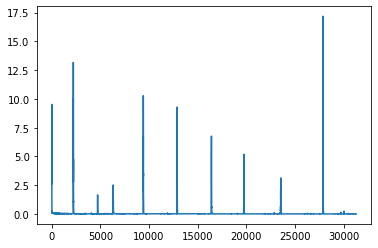

In [21]:
plt.plot(train_losses)
plt.show()

In [ ]:
sum(x.numel() for x in iwt_model.parameters())